In [1]:
import networkx as nx
import timeit
import numpy as np
import pandas as pd
import json
import random
import pickle
from math import log
from collections import Counter
import matplotlib.pyplot as plt

read files to get all modified_at timestamps:

In [17]:
start = timeit.default_timer()

# todo? add different weights to connections between song and artist/album/playlist in the graph??
G = nx.Graph()
num_files = 1000 # 1000 == all files
trim_start=len("spotify:")
playlist_times = np.empty(num_files * 1000)
for i in range(num_files):
    lb = i*1000
    ub = lb+999
    #print(f"mpd.slice.{lb}-{ub}.json")
    filename = f"spotify_million_playlist_dataset/data/mpd.slice.{lb}-{ub}.json"
    with open(filename) as read_file:
        tmp = json.load(read_file)
        for playlist in tmp["playlists"]:
            playlist_times[playlist["pid"]] = (playlist["modified_at"])

    time_elapsed = timeit.default_timer() - start
    mins_elapsed = (time_elapsed)//60
    secs_elapsed = time_elapsed % 60
    print(f"{i+1}/{num_files}; n:{G.number_of_nodes()}, m:{G.number_of_edges()}; time elapsed: {mins_elapsed:02} min {secs_elapsed:02.1f} sec", end="\r")
print(f"n:{G.number_of_nodes()}, m:{G.number_of_edges()}")

stop = timeit.default_timer()
print('Time elapsed (minutes):', (stop - start)/60)  

1/1; n:0, m:0; time elapsed: 0.0 min 1.7 sec
n:0, m:0
Time elapsed (minutes): 0.028635004999997212


In [39]:
ser = pd.Series(playlist_times)
ser = pd.to_datetime(ser, unit='s', errors='coerce')
# ser = ser[ser > pd.Timestamp("2000-01-01 00:00:00")]
ser.describe()

count                          1000000
mean     2016-10-12 13:36:12.729600256
min                2010-04-16 00:00:00
25%                2016-03-26 00:00:00
50%                2017-03-23 00:00:00
75%                2017-09-15 00:00:00
max                2017-11-01 00:00:00
dtype: object

In [48]:
np.percentile(ser, 80)

numpy.datetime64('2017-10-03T00:00:00.000000000')

In [52]:
np.count_nonzero(ser > pd.Timestamp("2017-09-15 00:00:00"))

249413

<Axes: >

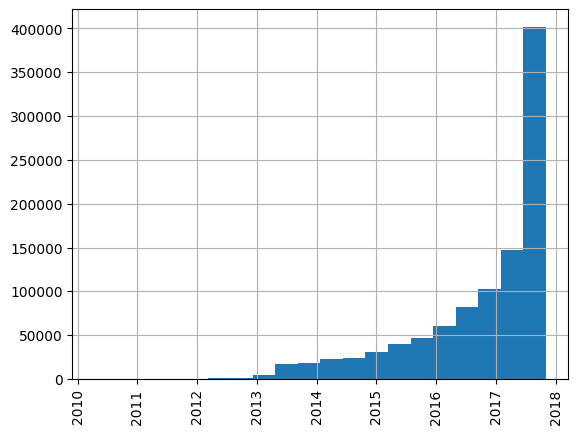

In [40]:
ser.hist(xrot=90, bins=20)

In [2]:
random.seed(0)

start = timeit.default_timer()

#to calculate statistics about artists
total_playlists = 0
total_tracks = 0
tracks = set()
artists = set()
albums = set()
titles = set()

# todo? add different weights to connections between song and artist/album/playlist in the graph??
G = nx.Graph()
num_files = 1000 # 1000 == all files
trim_start=len("spotify:")
for i in range(num_files):
    lb = i*1000
    ub = lb+999
    #print(f"mpd.slice.{lb}-{ub}.json")
    filename = f"data/mpd.slice.{lb}-{ub}.json"
    with open(filename) as read_file:
        tmp = json.load(read_file)
        for playlist in tmp["playlists"]:
            total_playlists += 1
            titles.add(playlist["name"])
            G.add_node(playlist["pid"], playlist_name=playlist["name"])#, num_tracks=playlist["num_tracks"], num_albums=playlist["num_albums"])#, collaborative=playlist["collaborative"], modified_at=playlist["modified_at"])
            for track in playlist["tracks"]:
                total_tracks += 1
                albums.add(track["album_uri"])
                tracks.add(track["track_uri"])
                artists.add(track["artist_uri"])
                track_id = track["track_uri"][trim_start:]
                artist_id = track["artist_uri"][trim_start:]
                album_id = track["album_uri"][trim_start:]
                G.add_node(track_id, track_name=track["track_name"], artist_name=track["artist_name"])#, album_name=track["album_name"])#, duration=track["duration_ms"])
                G.add_node(artist_id, artist_name=track["artist_name"])
                G.add_node(album_id, album_name=track["album_name"])
                # G.add_edge(track_id, artist_id) # dont need since songs are connected to artists via albums
                G.add_edge(track_id, album_id)
                G.add_edge(album_id, artist_id)
                G.add_edge(track_id, playlist["pid"])
    time_elapsed = timeit.default_timer() - start
    mins_elapsed = (time_elapsed)//60
    secs_elapsed = time_elapsed % 60
    print(f"{i+1}/{num_files}; time elapsed: {mins_elapsed:02} min {secs_elapsed:02.1f} sec", end="\r")
print()
print(f"n:{G.number_of_nodes()}, m:{G.number_of_edges()}")
    
stop = timeit.default_timer()
print('Time elapsed (minutes):', (stop - start)/60)  

# save the read graph into a pickle file to read it in faster next time
pickle.dump(G, open("./pickledata/spotify.pickle", 'wb'))

In [2]:
G = pickle.load(open("pickledata/spotify.pickle", "rb"))

In [3]:
start = timeit.default_timer()
n = G.number_of_nodes()
m = G.number_of_edges()
connected_c = list(nx.connected_components(G))
lcc = max(connected_c, key=len)
neighbour_avg_degs = nx.average_neighbor_degree(G)
max_avg_neighs = max(list(neighbour_avg_degs.values()))
max_degree = max(G.degree, key=lambda x: x[1])[1]
time_elapsed = timeit.default_timer() - start
mins_elapsed = (time_elapsed)//60
secs_elapsed = time_elapsed % 60
print(f"num_files: {num_files}")
print(f"time elapsed: {mins_elapsed:02} min {secs_elapsed:02.1f} sec", end="\r")

NameError: name 'num_files' is not defined

In [10]:
print("stats about data")
print("number of playlists", total_playlists)
print("number of tracks", total_tracks)
print("number of unique tracks", len(tracks))
print("number of unique albums", len(albums))
print("number of unique artists", len(artists))
print("number of unique titles", len(titles))
print("avg playlist length", float(total_tracks) / total_playlists)

stats about data
number of playlists 1000000
number of tracks 66346428
number of unique tracks 2262292
number of unique albums 734684
number of unique artists 295860
number of unique titles 92944
avg playlist length 66.346428


In [11]:
print("stats about graph")
print(f"number of nodes: {n}")
print(f"number of edges: {m}")
print(f"clustering: {0}")
print(f"connected compoentns: {len(connected_c)}")
print(f"largest connected compoentns: {len(lcc)}")
print(f"averag degree: {2*m/n}")
print(f"averag distance: {log(n) / log(2*m/n)}")
print(f"maximum degree: {max_degree}")
print(f"density: {nx.density(G)}")
print(f"maximum average neighbour degree: {max_avg_neighs}")

stats about graph
number of nodes: 4292836
number of edges: 68576834
clustering: 0
connected compoentns: 23
largest connected compoentns: 4291256
averag degree: 31.949431098695594
averag distance: 4.408711764231212
maximum degree: 45395
density: 7.442501540053507e-06
maximum average neighbour degree: 33050.833333333336


In [15]:
def ploter(all_deg, filename=None):
        degree_counts = Counter(all_deg)
        x, y = zip(*degree_counts.items())

        plt.figure(1)
        plt.xlabel('degree')
        plt.xscale('log')
        plt.xlim(1, max(x))
        plt.ylabel('frequency')
        plt.yscale('log')
        plt.ylim(1, max(y))
        plt.scatter(x, y, marker='.')
        if filename is not None:
                plt.savefig(filename)
        plt.show()

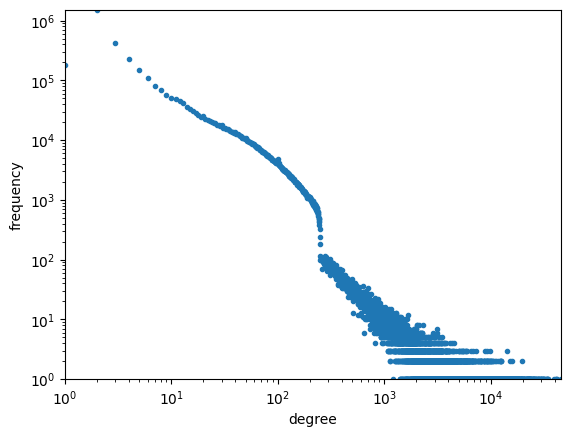

In [16]:
ploter([x for _,x in nx.degree(G)], filename="loglog-degree.png")

In [44]:
ctr=1
for id in G:
    if (type(id) == int):
        print(id)
    ctr +=1
    if ctr > 10000:
        break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94


In [28]:
song_degs = [len(list(G.neighbors(id))) for id in G if type(id) != int and id.startswith("track:")]

In [45]:
playlist_degs = [len(list(G.neighbors(id))) for id in G if type(id) == int]

In [31]:
songsx, songsy = zip(*Counter(song_degs).items())

In [46]:
pd.Series(song_degs).describe()

count    2.261225e+06
mean     2.992309e+01
std      3.548826e+02
min      2.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      6.000000e+00
max      4.535100e+04
dtype: float64

In [47]:
plstx, plsty = zip(*Counter(playlist_degs).items())

In [48]:
pd.Series(playlist_degs).describe()

count    999000.000000
mean         65.467084
std          52.706999
min           3.000000
25%          26.000000
50%          49.000000
75%          90.000000
max         341.000000
dtype: float64

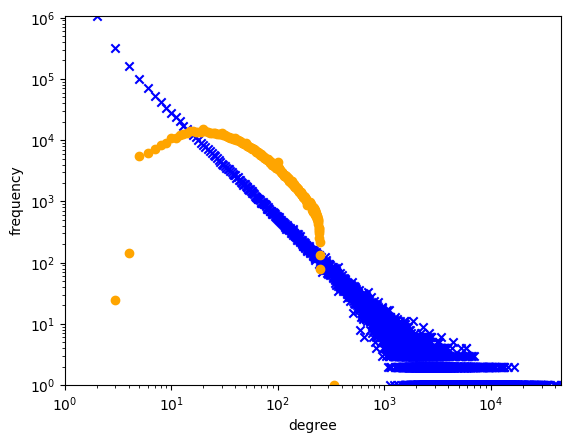

In [49]:
plt.figure(2)
plt.xlabel('degree')
plt.xscale('log')
plt.xlim(1, max(max(songsx),max(plstx)))
plt.ylabel('frequency')
plt.yscale('log')
plt.ylim(1, max(max(songsy), max(plsty)))
plt.scatter(songsx, songsy, marker="x", c="blue")
plt.scatter(plstx, plsty, marker="o", c="orange")
plt.savefig("loglog-deg-songs-playlists.png")
plt.show()

In [5]:
small_cs= sorted(connected_c, key=len)[:-1]

In [11]:
smc_lens = pd.Series([len(c) for c in small_cs])
smc_lens.describe()

count     22.000000
mean      71.818182
std       59.952867
min       12.000000
25%       20.250000
50%       61.000000
75%       99.000000
max      237.000000
dtype: float64

In [20]:
for c in small_cs:
    tmp = list(c)
    print([f"playlist id:{id}; name: {G.nodes[id]['playlist_name']}" for id in tmp if type(id) == int])
    print([G.nodes[id] for id in tmp if type(id) != int and id.startswith("artist")])
    print([G.nodes[id] for id in tmp[:15] if type(id) != int and not id.startswith("artist")])
    print()
    # break

['playlist id:446994; name: MEDITATIONS']
[{'artist_name': 'Emma Louise Parish'}, {'artist_name': 'Bart Milatz'}, {'artist_name': 'Shannon R Rios'}]
[{'album_name': 'Manifesting Abundance: Guided Meditation and Creative Visualization'}, {'track_name': 'Hypnotherapy for Manifesting Abundance, Wealth and Prosperity', 'artist_name': 'Bart Milatz'}, {'album_name': 'Meditations for Manifesting Abundance and Prosperity'}, {'track_name': 'Deserving and Worthiness Meditation: The Foundation of Manifesting', 'artist_name': 'Shannon R Rios'}, {'track_name': 'Morning Meditation for Manifesting Abundance, Wealth and Prosperity', 'artist_name': 'Bart Milatz'}, {'album_name': 'The Healing Journey Within: Meditations for Abundance and Love, Vol. I (Deserving)'}, {'track_name': 'Evening Meditation for Manifesting Abundance, Wealth and Prosperity', 'artist_name': 'Bart Milatz'}, {'track_name': 'Manifesting Abundance: Guided Meditation and Creative Visualization', 'artist_name': 'Emma Louise Parish'}]

